<a href="https://colab.research.google.com/github/tmattkim/cardioslice/blob/main/finalUnetCMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'unetCMR/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install monai nibabel scikit-learn scikit-image tqdm numpy

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import os
import glob
import torch
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split, KFold
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld,
    ResizeWithPadOrCropd, CastToTyped, EnsureTyped, ToTensord
)
from monai.data import CacheDataset, DataLoader
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.networks.utils import one_hot

# Config
root_dir = "/content/drive/MyDrive/unetCMR/25226363/cropped_norm"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1
num_epochs = 50
img_size = (128, 128, 128)
num_classes = 9
learning_rate = 1e-4
seed = 42
set_determinism(seed)

# Data
def get_hvsmr_cases(data_dir):
    images = sorted(glob.glob(os.path.join(data_dir, "pat*_cropped_norm.nii.gz")))
    labels = sorted(glob.glob(os.path.join(data_dir, "pat*_cropped_seg.nii.gz")))
    assert len(images) == len(labels), "Mismatch between images and labels!"
    return [{"image": img, "label": seg} for img, seg in zip(images, labels)]

data_dicts = get_hvsmr_cases(root_dir)
trainval_files, test_files = train_test_split(data_dicts, test_size=0.2, random_state=seed)

# Transforms
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-100, a_max=500, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=img_size),
    RandCropByPosNegLabeld(
        keys=["image", "label"], label_key="label", spatial_size=img_size,
        pos=1, neg=1, num_samples=4, image_key="image", image_threshold=0
    ),
    CastToTyped(keys=["label"], dtype=torch.long),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-100, a_max=500, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=img_size),
    CastToTyped(keys=["label"], dtype=torch.long),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"]),
])

test_transforms = val_transforms

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

for fold, (train_idx, val_idx) in enumerate(kf.split(trainval_files)):
    print(f"\n--- Fold {fold + 1}/5 ---")
    train_files = [trainval_files[i] for i in train_idx]
    val_files = [trainval_files[i] for i in val_idx]

    train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
    val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
    test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=True)

    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=num_classes,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for step, batch_data in enumerate(train_loader, 1):
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            print(f" Step {step}/{len(train_loader)} - Loss: {loss.item():.4f}")
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch + 1} average loss: {avg_loss:.4f}")

        model.eval()
        dice_metric.reset()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_labels = val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_inputs, roi_size=img_size, sw_batch_size=1, predictor=model)
                val_outputs_labels = torch.argmax(val_outputs, dim=1, keepdim=True)
                val_labels_onehot = one_hot(val_labels, num_classes=num_classes)
                dice_metric(y_pred=val_outputs_labels, y=val_labels_onehot)
        mean_dice = dice_metric.aggregate().item()
        print(f"Validation Dice score: {mean_dice:.4f}")

        save_path = f"/content/drive/MyDrive/unetCMR/unet_fold{fold+1}_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)

    val_sample = next(iter(val_loader))
    model.eval()
    with torch.no_grad():
        input_img = val_sample["image"].to(device)
        label_img = val_sample["label"].to(device)
        pred_img = sliding_window_inference(input_img, roi_size=img_size, sw_batch_size=1, predictor=model)
        pred_class = torch.argmax(pred_img, dim=1)

    np.save(f"/content/drive/MyDrive/unetCMR/fold{fold+1}_input_img.npy", input_img[0, 0].cpu().numpy())
    np.save(f"/content/drive/MyDrive/unetCMR/fold{fold+1}_label_img.npy", label_img[0].cpu().numpy())
    np.save(f"/content/drive/MyDrive/unetCMR/fold{fold+1}_pred_img.npy", pred_class[0].cpu().numpy())



--- Fold 1/5 ---


Loading dataset: 100%|██████████| 12/12 [00:09<00:00,  1.24it/s]
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


 Step 1/38 - Loss: 3.3210
 Step 2/38 - Loss: 3.2835
 Step 3/38 - Loss: 3.2860
 Step 4/38 - Loss: 3.2612
 Step 5/38 - Loss: 3.2339
 Step 6/38 - Loss: 3.2137
 Step 7/38 - Loss: 3.1997
 Step 8/38 - Loss: 3.1772
 Step 9/38 - Loss: 3.1589
 Step 10/38 - Loss: 3.1493
 Step 11/38 - Loss: 3.1279
 Step 12/38 - Loss: 3.1251
 Step 13/38 - Loss: 3.0934
 Step 14/38 - Loss: 3.0822
 Step 15/38 - Loss: 3.0635
 Step 16/38 - Loss: 3.0491
 Step 17/38 - Loss: 3.0376
 Step 18/38 - Loss: 3.0269
 Step 19/38 - Loss: 3.0381
 Step 20/38 - Loss: 2.9814
 Step 21/38 - Loss: 2.9569
 Step 22/38 - Loss: 2.9605
 Step 23/38 - Loss: 2.9199
 Step 24/38 - Loss: 2.9261
 Step 25/38 - Loss: 2.9138
 Step 26/38 - Loss: 2.9348
 Step 27/38 - Loss: 2.8773
 Step 28/38 - Loss: 2.8755
 Step 29/38 - Loss: 2.8651
 Step 30/38 - Loss: 2.8490
 Step 31/38 - Loss: 2.8403
 Step 32/38 - Loss: 2.8369
 Step 33/38 - Loss: 2.8286
 Step 34/38 - Loss: 2.8774
 Step 35/38 - Loss: 2.8071
 Step 36/38 - Loss: 2.7710
 Step 37/38 - Loss: 2.7601
 Step 38/3

Loading dataset: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s]


 Step 1/38 - Loss: 3.4974
 Step 2/38 - Loss: 3.4197
 Step 3/38 - Loss: 3.4901
 Step 4/38 - Loss: 3.3715
 Step 5/38 - Loss: 3.4465
 Step 6/38 - Loss: 3.3877
 Step 7/38 - Loss: 3.3739
 Step 8/38 - Loss: 3.3138
 Step 9/38 - Loss: 3.3621
 Step 10/38 - Loss: 3.3456
 Step 11/38 - Loss: 3.3077
 Step 12/38 - Loss: 3.2539
 Step 13/38 - Loss: 3.2961
 Step 14/38 - Loss: 3.2709
 Step 15/38 - Loss: 3.2183
 Step 16/38 - Loss: 3.2612
 Step 17/38 - Loss: 3.2266
 Step 18/38 - Loss: 3.2240
 Step 19/38 - Loss: 3.1796
 Step 20/38 - Loss: 3.1905
 Step 21/38 - Loss: 3.1596
 Step 22/38 - Loss: 3.1444
 Step 23/38 - Loss: 3.1642
 Step 24/38 - Loss: 3.1411
 Step 25/38 - Loss: 3.1128
 Step 26/38 - Loss: 3.1117
 Step 27/38 - Loss: 3.1066
 Step 28/38 - Loss: 3.1092
 Step 29/38 - Loss: 3.0995
 Step 30/38 - Loss: 3.0817
 Step 31/38 - Loss: 3.0961
 Step 32/38 - Loss: 3.0720
 Step 33/38 - Loss: 3.0267
 Step 34/38 - Loss: 3.0192
 Step 35/38 - Loss: 3.0128
 Step 36/38 - Loss: 3.0446
 Step 37/38 - Loss: 3.0198
 Step 38/3

Loading dataset: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]


 Step 1/38 - Loss: 3.4531
 Step 2/38 - Loss: 3.4263
 Step 3/38 - Loss: 3.4115
 Step 4/38 - Loss: 3.3949
 Step 5/38 - Loss: 3.3608
 Step 6/38 - Loss: 3.3388
 Step 7/38 - Loss: 3.3257
 Step 8/38 - Loss: 3.3005
 Step 9/38 - Loss: 3.2653
 Step 10/38 - Loss: 3.2516
 Step 11/38 - Loss: 3.2654
 Step 12/38 - Loss: 3.2086
 Step 13/38 - Loss: 3.1960
 Step 14/38 - Loss: 3.1836
 Step 15/38 - Loss: 3.1738
 Step 16/38 - Loss: 3.1765
 Step 17/38 - Loss: 3.1403
 Step 18/38 - Loss: 3.1374
 Step 19/38 - Loss: 3.0923
 Step 20/38 - Loss: 3.1040
 Step 21/38 - Loss: 3.0604
 Step 22/38 - Loss: 3.1102
 Step 23/38 - Loss: 3.0568
 Step 24/38 - Loss: 2.9991
 Step 25/38 - Loss: 2.9930
 Step 26/38 - Loss: 2.9726
 Step 27/38 - Loss: 2.9942
 Step 28/38 - Loss: 2.9639
 Step 29/38 - Loss: 2.9366
 Step 30/38 - Loss: 2.9280
 Step 31/38 - Loss: 2.9458
 Step 32/38 - Loss: 2.9125
 Step 33/38 - Loss: 2.9060
 Step 34/38 - Loss: 2.8867
 Step 35/38 - Loss: 2.9282
 Step 36/38 - Loss: 2.8586
 Step 37/38 - Loss: 2.8578
 Step 38/3

Loading dataset: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


 Step 1/39 - Loss: 3.5027
 Step 2/39 - Loss: 3.5383
 Step 3/39 - Loss: 3.4216
 Step 4/39 - Loss: 3.4087
 Step 5/39 - Loss: 3.4592
 Step 6/39 - Loss: 3.4562
 Step 7/39 - Loss: 3.4070
 Step 8/39 - Loss: 3.4068
 Step 9/39 - Loss: 3.3971
 Step 10/39 - Loss: 3.3582
 Step 11/39 - Loss: 3.3147
 Step 12/39 - Loss: 3.2796
 Step 13/39 - Loss: 3.2739
 Step 14/39 - Loss: 3.2896
 Step 15/39 - Loss: 3.2519
 Step 16/39 - Loss: 3.2711
 Step 17/39 - Loss: 3.2293
 Step 18/39 - Loss: 3.2158
 Step 19/39 - Loss: 3.2156
 Step 20/39 - Loss: 3.1787
 Step 21/39 - Loss: 3.1681
 Step 22/39 - Loss: 3.1734
 Step 23/39 - Loss: 3.1645
 Step 24/39 - Loss: 3.1119
 Step 25/39 - Loss: 3.1089
 Step 26/39 - Loss: 3.1661
 Step 27/39 - Loss: 3.1353
 Step 28/39 - Loss: 3.1127
 Step 29/39 - Loss: 3.0720
 Step 30/39 - Loss: 3.0844
 Step 31/39 - Loss: 3.1102
 Step 32/39 - Loss: 3.0655
 Step 33/39 - Loss: 3.0933
 Step 34/39 - Loss: 3.0146
 Step 35/39 - Loss: 3.0075
 Step 36/39 - Loss: 3.0577
 Step 37/39 - Loss: 3.0062
 Step 38/3

Loading dataset: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


 Step 1/39 - Loss: 3.4748
 Step 2/39 - Loss: 3.4309
 Step 3/39 - Loss: 3.4739
 Step 4/39 - Loss: 3.3880
 Step 5/39 - Loss: 3.4175
 Step 6/39 - Loss: 3.4445
 Step 7/39 - Loss: 3.4085
 Step 8/39 - Loss: 3.4005
 Step 9/39 - Loss: 3.3803
 Step 10/39 - Loss: 3.3143
 Step 11/39 - Loss: 3.3478
 Step 12/39 - Loss: 3.3138
 Step 13/39 - Loss: 3.2907
 Step 14/39 - Loss: 3.2689
 Step 15/39 - Loss: 3.2352
 Step 16/39 - Loss: 3.2282
 Step 17/39 - Loss: 3.2153
 Step 18/39 - Loss: 3.2114
 Step 19/39 - Loss: 3.1780
 Step 20/39 - Loss: 3.1561
 Step 21/39 - Loss: 3.1815
 Step 22/39 - Loss: 3.1546
 Step 23/39 - Loss: 3.1501
 Step 24/39 - Loss: 3.0902
 Step 25/39 - Loss: 3.1148
 Step 26/39 - Loss: 3.0950
 Step 27/39 - Loss: 3.0882
 Step 28/39 - Loss: 3.0555
 Step 29/39 - Loss: 3.0752
 Step 30/39 - Loss: 3.0346
 Step 31/39 - Loss: 3.0162
 Step 32/39 - Loss: 3.0140
 Step 33/39 - Loss: 2.9879
 Step 34/39 - Loss: 3.0190
 Step 35/39 - Loss: 2.9872
 Step 36/39 - Loss: 2.9765
 Step 37/39 - Loss: 2.9318
 Step 38/3

In [ ]:
import os
import glob
import torch
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split, KFold
from monai.networks.nets import UNet
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld,
    ResizeWithPadOrCropd, CastToTyped, EnsureTyped, ToTensord
)
from monai.data import CacheDataset, DataLoader
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.networks.utils import one_hot

# Config
root_dir = "/content/drive/MyDrive/unetCMR/25226363/cropped_norm"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1
num_epochs = 100
img_size = (128, 128, 128)
num_classes = 9
learning_rate = 1e-4
seed = 42
set_determinism(seed)

# Early stopping parameters
patience = 10
best_loss = float("inf")
epochs_no_improve = 0
early_stop = False

# Data
def get_hvsmr_cases(data_dir):
    images = sorted(glob.glob(os.path.join(data_dir, "pat*_cropped_norm.nii.gz")))
    labels = sorted(glob.glob(os.path.join(data_dir, "pat*_cropped_seg.nii.gz")))
    assert len(images) == len(labels), "Mismatch between images and labels!"
    return [{"image": img, "label": seg} for img, seg in zip(images, labels)]

data_dicts = get_hvsmr_cases(root_dir)

# Split into 80% train and 20% test
trainval_files, test_files = train_test_split(data_dicts, test_size=0.2, random_state=seed)

# Transforms
common_transforms = [
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-100, a_max=500, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=img_size),
    CastToTyped(keys=["label"], dtype=torch.long),
    EnsureTyped(keys=["image", "label"]),
    ToTensord(keys=["image", "label"]),
]

train_transforms = Compose(common_transforms + [
    RandCropByPosNegLabeld(
        keys=["image", "label"], label_key="label", spatial_size=img_size,
        pos=1, neg=1, num_samples=4, image_key="image", image_threshold=0
    ),
])

val_transforms = Compose(common_transforms)

test_transforms = val_transforms

# Load data
trainval_ds = CacheDataset(data=trainval_files, transform=train_transforms, cache_rate=1.0)
trainval_loader = DataLoader(trainval_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2, pin_memory=True)

# Model
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
dice_metric = DiceMetric(include_background=False, reduction="mean")

scaler = GradScaler()

# Training loop
for epoch in range(num_epochs):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    model.train()
    epoch_loss = 0
    for step, batch_data in enumerate(trainval_loader, 1):
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(f" Step {step}/{len(trainval_loader)} - Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(trainval_loader)
    print(f"Epoch {epoch + 1} average loss: {avg_loss:.4f}")

    # Save model checkpoint
    save_path = f"/content/drive/MyDrive/unetCMR/final_unet_model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), save_path)

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
        print("Loss improved; resetting patience.")
    else:
        epochs_no_improve += 1
        print(f"No improvement. Patience counter: {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            early_stop = True

# Test evaluation
model.eval()
dice_metric.reset()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)
        test_outputs = sliding_window_inference(test_inputs, roi_size=img_size, sw_batch_size=1, predictor=model)
        test_outputs_labels = torch.argmax(test_outputs, dim=1, keepdim=True)
        test_labels_onehot = one_hot(test_labels, num_classes=num_classes)
        dice_metric(y_pred=test_outputs_labels, y=test_labels_onehot)
mean_dice = dice_metric.aggregate().item()
print(f"Test Dice score: {mean_dice:.4f}")

# Save prediction sample
test_sample = next(iter(test_loader))
model.eval()
with torch.no_grad():
    input_img = test_sample["image"].to(device)
    label_img = test_sample["label"].to(device)
    pred_img = sliding_window_inference(input_img, roi_size=img_size, sw_batch_size=1, predictor=model)
    pred_class = torch.argmax(pred_img, dim=1)

np.save("/content/drive/MyDrive/unetCMR/input_img.npy", input_img[0, 0].cpu().numpy())
np.save("/content/drive/MyDrive/unetCMR/label_img.npy", label_img[0].cpu().numpy())
np.save("/content/drive/MyDrive/unetCMR/pred_img.npy", pred_class[0].cpu().numpy())
print("Saved input, label, and prediction arrays.")

Loading dataset: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Streaming output truncated to the last 5000 lines.
 Step 3/48 - Loss: 3.2778
 Step 4/48 - Loss: 3.2472
 Step 5/48 - Loss: 3.2384
 Step 6/48 - Loss: 3.2163
 Step 7/48 - Loss: 3.1846
 Step 8/48 - Loss: 3.1869
 Step 9/48 - Loss: 3.1660
 Step 10/48 - Loss: 3.1459
 Step 11/48 - Loss: 3.1467
 Step 12/48 - Loss: 3.0928
 Step 13/48 - Loss: 3.0925
 Step 14/48 - Loss: 3.0636
 Step 15/48 - Loss: 3.0835
 Step 16/48 - Loss: 3.0451
 Step 17/48 - Loss: 3.0351
 Step 18/48 - Loss: 3.0147
 Step 19/48 - Loss: 3.0030
 Step 20/48 - Loss: 2.9788
 Step 21/48 - Loss: 2.9553
 Step 22/48 - Loss: 3.0036
 Step 23/48 - Loss: 2.9387
 Step 24/48 - Loss: 2.9174
 Step 25/48 - Loss: 2.9088
 Step 26/48 - Loss: 2.8856
 Step 27/48 - Loss: 2.8968
 Step 28/48 - Loss: 2.8442
 Step 29/48 - Loss: 2.8660
 Step 30/48 - Loss: 2.8695
 Step 31/48 - Loss: 2.8291
 Step 32/48 - Loss: 2.8282
 Step 33/48 - Loss: 2.8647
 Step 34/48 - Loss: 2.8237
 Step 35/48 - Loss: 2.7986
 Step 36/48 - Loss: 2.7802
 Step 37/48 - Loss: 2.7701
 Step 38/48

In [ ]:
# Final Test Evaluation
print("\n--- Final Test Evaluation on Held-out Test Set ---")
model.eval()
dice_metric.reset()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)
        test_outputs = sliding_window_inference(test_inputs, roi_size=img_size, sw_batch_size=1, predictor=model)
        test_outputs_labels = torch.argmax(test_outputs, dim=1, keepdim=True)
        test_labels_onehot = one_hot(test_labels, num_classes=num_classes)
        dice_metric(y_pred=test_outputs_labels, y=test_labels_onehot)

mean_dice = dice_metric.aggregate().item()
print(f"Test Dice score: {mean_dice:.4f}")


--- Final Test Evaluation on Held-out Test Set ---
Test Dice score: 0.5207


img shape: (128, 128, 128)
label shape: (1, 128, 128, 128)
pred shape: (128, 128, 128)


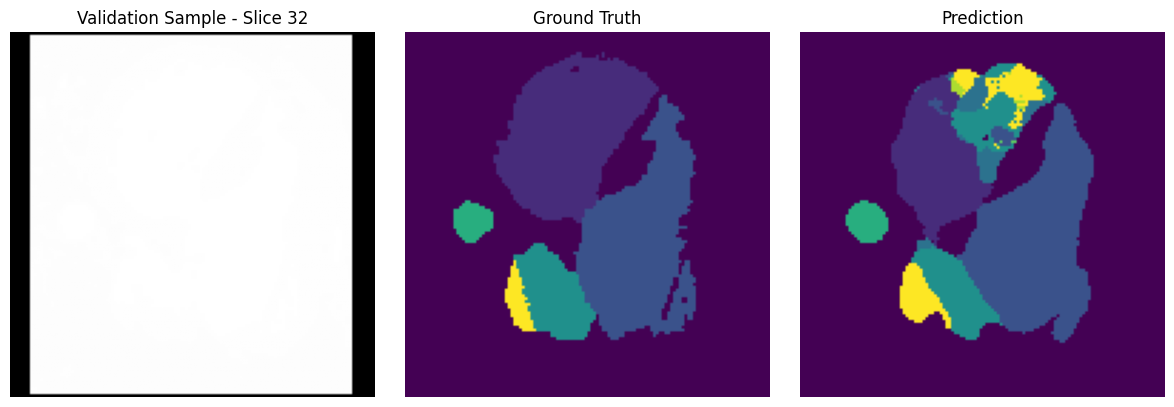

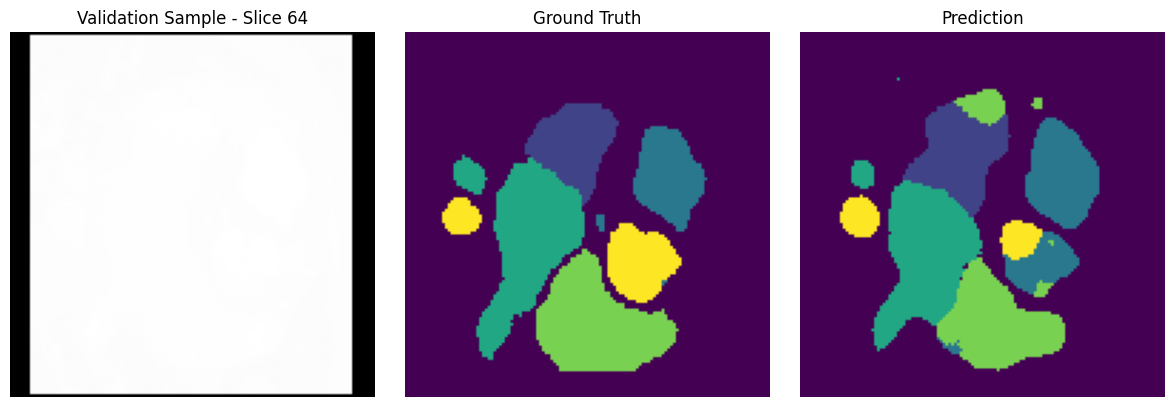

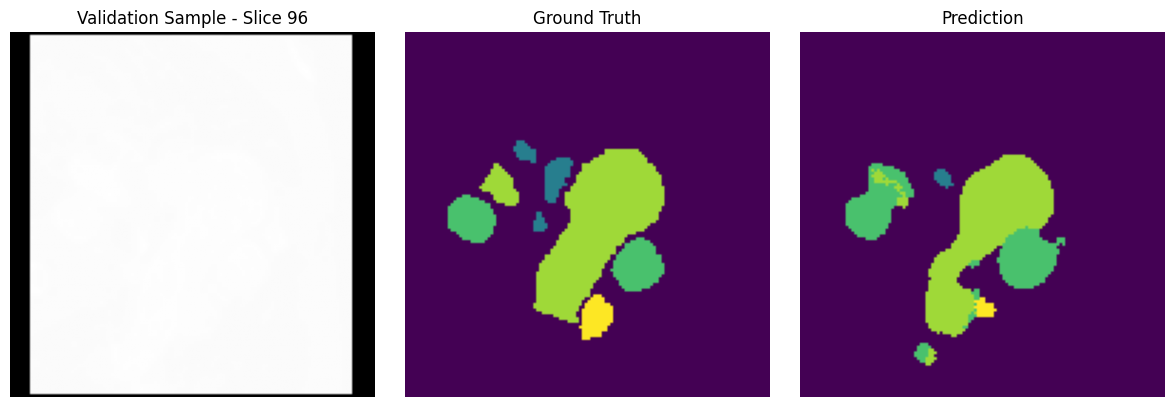

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the files
img_np = np.load("/content/drive/MyDrive/unetCMR/input_img.npy")
label_np = np.load("/content/drive/MyDrive/unetCMR/label_img.npy")
pred_np = np.load("/content/drive/MyDrive/unetCMR/pred_img.npy")

print("img shape:", img_np.shape)
print("label shape:", label_np.shape)
print("pred shape:", pred_np.shape)

# Remove singleton channel dimension if present
label_np = np.squeeze(label_np)

def show_slices(img, mask, pred, title):
    slices = [img.shape[-1] // 4, img.shape[-1] // 2, 3 * img.shape[-1] // 4]
    for i, idx in enumerate(slices):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img[:, :, idx], cmap="gray")
        plt.title(f"{title} - Slice {idx}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask[:, :, idx])
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred[:, :, idx])
        plt.title("Prediction")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

show_slices(img_np, label_np, pred_np, "Validation Sample")